In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [12]:
def load_data():
    
    df = pd.read_csv('../Smoothing and forecasting on TimeSeries/time_series_covid19_confirmed_global.csv')
    df = df.iloc[:, 4:]
    for i in df.columns:
        df[i] = df[i].sum()
    df = df.iloc[:1,:]
    df =df.T.reset_index()
    df['index'] = pd.to_datetime(df['index'])
    lst = []
    for i in range(len(df[0])-1):
        new_num = df[0][i+1] - df[0][i]
        lst.append(new_num.astype(float))
    daily_new_cases = pd.Series(lst, index = df['index'][1:])
    
    return daily_new_cases

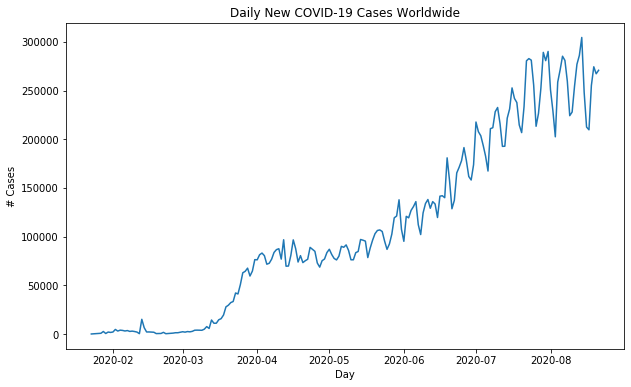

In [13]:
# Let's plot and see the time series

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(load_data())
ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")

del fig, ax

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose, DecomposeResult

def sea_decomp(ser, model="additive"):
    """
    Takes in a series and a "model" parameter indicating which seasonal decomp to perform
    """
    result = seasonal_decompose(ser, model = model)

    return result

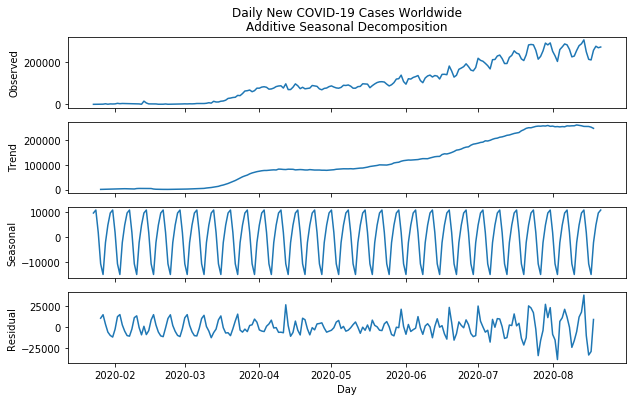

In [15]:
# Let's plot and see the seasonal decomposition

fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)
res = sea_decomp(load_data(), model="additive")

axes[0].set_title("Additive Seasonal Decomposition")
axes[0].plot(res.observed)
axes[0].set_ylabel("Observed")

axes[1].plot(res.trend)
axes[1].set_ylabel("Trend")

axes[2].plot(res.seasonal)
axes[2].set_ylabel("Seasonal")

axes[3].plot(res.resid)
axes[3].set_ylabel("Residual")

axes[3].set_xlabel("Day")
fig.suptitle("Daily New COVID-19 Cases Worldwide", x=0.513, y=0.95)

del fig, axes, res

In [16]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def fit_trend(ser, n):
    """
    Takes a series and fits an n-th order polynomial to the series. 
    Returns the predictions. 
    """
  
    train_X, train_y = np.linspace(1, len(ser.index), len(ser.index)), np.array(ser) # xi's and yi's

    pf = PolynomialFeatures(n)
    train_X = pf.fit_transform(train_X.reshape(-1, 1))
    lin_reg = LinearRegression().fit(train_X, train_y.reshape(-1))

    trend_curve = lin_reg.predict(train_X)

    
    return trend_curve

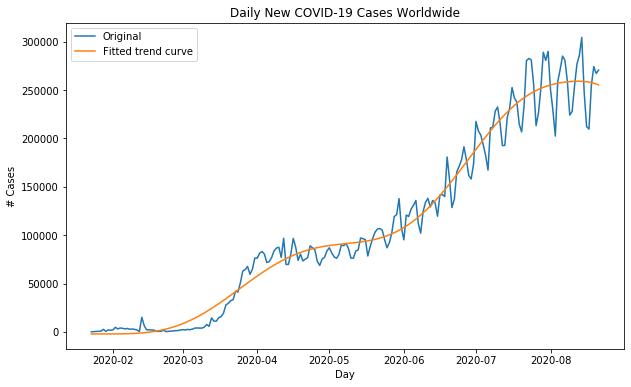

In [17]:
# Let's plot and see your regression line

fig, ax = plt.subplots(figsize=(10, 6))
ser = load_data()
preds = fit_trend(ser, 10)
ax.plot(ser.index, ser.values, label="Original")
ax.plot(ser.index, preds, label="Fitted trend curve")
ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")
ax.legend()

del fig, ax, ser, preds

In [18]:
def calc_wma(ser, wd_size, weights=1):
    """
    Takes in a series and calculates the WMA with a window size of wd_size
    """
    
    if isinstance(weights, int):
        weights = np.full(wd_size, weights, dtype=float)

    assert len(weights) == wd_size, "Q4: The size of the weights must be the same as the window size. "
    
    wma = []

    for i in ser.rolling(window = wd_size):
        total_w = 0
        b = 0
        for j,k in zip(weights, range(len(i))):    
            a = i[k]*(wd_size-len(i)+j)
            b = b + a
            total_w = total_w + (wd_size-len(i)+j)
        c = b/total_w
        wma.append(c)


    return np.array(wma)

In [20]:
def calc_wma(ser, wd_size, weights=1):
    """
    Takes in a series and calculates the WMA with a window size of wd_size
    """
    
    if isinstance(weights, int):
        weights = np.full(wd_size, weights, dtype=float)

    assert len(weights) == wd_size, "Q4: The size of the weights must be the same as the window size. "
    
    wma = []

    for i in ser.rolling(window = wd_size):
        total_w = 0
        b = 0
        for j,k in zip(weights, range(len(i))):    
            a = i[k]*(wd_size-len(i)+j)
            b = b + a
            total_w = total_w + (wd_size-len(i)+j)
        c = b/total_w
        wma.append(c)
    
    return np.array(wma)

In [22]:
def calc_time_ema(ser, lmbd=0.0):
    """
    Takes in a series and calculates EMA with the lambda provided
    """
    b = 0
    j = 0
    time_ema = []
    for i in range(1,len(ser)+1):
        time = ser.index
        k = np.exp((-lmbd)*((time[len(ser)-1]-time[i-1]).days))
        a = k*ser[i-1]
        b = b + a
        j = j + k
        c = b/j
        time_ema.append(c)

    
    return np.array(time_ema)

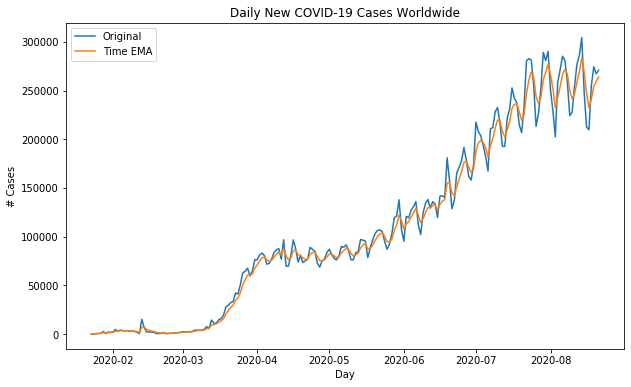

In [23]:
# Let's plot and see your time EMA

fig, ax = plt.subplots(figsize=(10, 6))
ser = load_data()
ema = calc_time_ema(ser, lmbd=0.5)

ax.plot(ser.index, ser.to_numpy(), label="Original")
ax.plot(ser.index, ema, label="Time EMA")
ax.set_xlabel("Day")

ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")
ax.legend()

del fig, ax, ser, ema

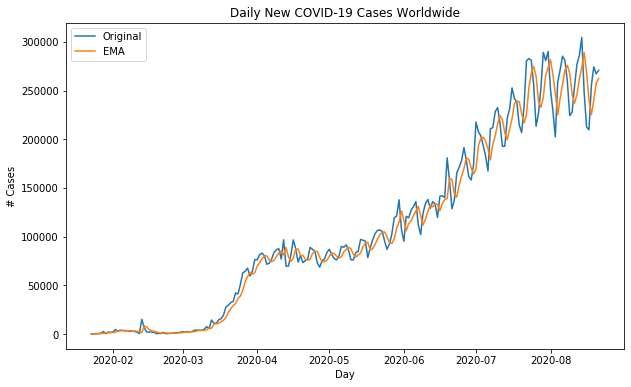

In [25]:
from statsmodels.tsa.api import SimpleExpSmoothing

fig, ax = plt.subplots(figsize=(10, 6))

ser = load_data()
ema = SimpleExpSmoothing(ser).fit(smoothing_level=0.5, optimized=False)

ax.plot(ser, label="Original")
ax.plot(ema.fittedvalues, label="EMA")
ax.set_xlabel("Day")
ax.set_ylabel("# Cases")
ax.set_title("Daily New COVID-19 Cases Worldwide")
ax.legend()

del ser, ema, fig, ax

In [28]:
def load_data():
    
    df = pd.read_csv('../Smoothing and forecasting on TimeSeries/time_series_covid19_confirmed_global.csv')

    df = df.drop(columns = ['Province/State','Lat','Long'])
    df.sort_values('8/21/20', ascending = False, inplace = True)
    df = df.iloc[:5,:]
    df.set_index('Country/Region',inplace = True)
    df =df.T
    df.columns.name = None
    df.index = pd.to_datetime(df.index)
    
    lst=[]
    for i in range(len(df)-1):
        new = (df.iloc[i+1] - df.iloc[i]).astype(float)
        lst.append(new)

    df_new = pd.DataFrame(lst)
    df_new.index = df.index[1:]
    
    daily_new_cases = df_new
    
    return daily_new_cases

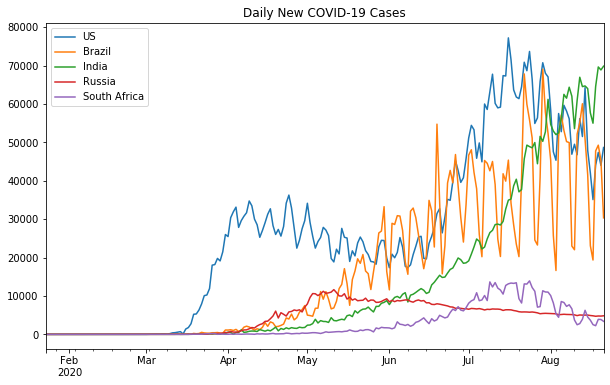

In [31]:
# Let's plot and see the time series
axes = load_data().plot(figsize=(10, 6), title="Daily New COVID-19 Cases")

del axes

In [32]:
from statsmodels.tsa.seasonal import seasonal_decompose

def sea_decomp(df, model="additive"):
    """
    Takes in a DataFrame and extracts the seasonal components
    """
    df = load_data()
    sea_df = pd.DataFrame()

    for i in df.columns:
        new = seasonal_decompose(df[i], model="additive").seasonal
        sea_df[i] = new
    
    return sea_df

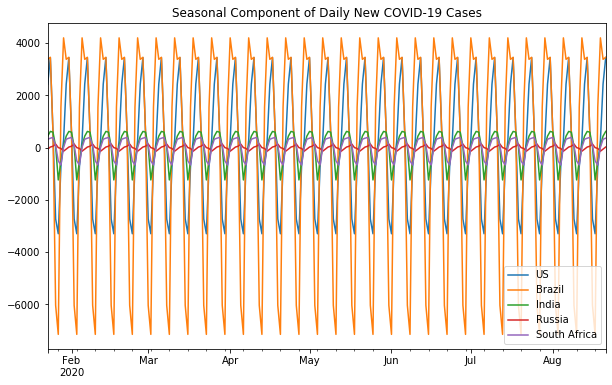

In [33]:
# Let's plot and see the seasonal components

df = load_data()
axes = sea_decomp(df).plot(figsize=(10, 6), title="Seasonal Component of Daily New COVID-19 Cases")

del df, axes

In [34]:
def calc_euclidean_dist(df):
    """
    Takes in a DataFrame and computes all pairwise Euclidean Distance
    """
    b = 0
    new_df = []

    for i in df.columns:
        lst = []
        for k in df.columns:
            a = (((df[i] - df[k])**2).sum())**0.5
            lst.append(a)
        new_df.append(lst)
    euclidean_dist_df = pd.DataFrame(data = new_df)
    euclidean_dist_df.index = df.columns
    euclidean_dist_df.columns = df.columns

    return euclidean_dist_df

In [35]:
calc_euclidean_dist(load_data())

,US,Brazil,India,Russia,South Africa
US,0.000000,233760.757213,272344.138927,433638.331574,436238.175972
Brazil,233760.757213,0.000000,178779.663740,306032.283923,304919.698741
India,272344.138927,178779.663740,0.000000,316862.767630,303936.538967
Russia,433638.331574,306032.283923,316862.767630,0.000000,67392.593681
South Africa,436238.175972,304919.698741,303936.538967,67392.593681,0.000000


In [36]:
def calc_cos_sim(df):
    """
    Takes in a DataFrame and computes all pairwise Cosine Similarity
    """
    
    b = 0
    new_df = []

    for i in df.columns:
        lst = []
        for k in df.columns:
            a = (df[i]*df[k]).sum()/((((df[i]**2).sum())**0.5)*(((df[k]**2).sum())**0.5))
            lst.append(a)
        new_df.append(lst)
    cos_sim_df = pd.DataFrame(data = new_df)
    cos_sim_df.index = df.columns
    cos_sim_df.columns = df.columns

    
    return cos_sim_df

In [37]:
# Let's show the pairwise Cosine Similarity matrix

df = load_data()
calc_cos_sim(sea_decomp(df))

,US,Brazil,India,Russia,South Africa
US,1.000000,0.868859,0.783851,-0.325065,0.664261
Brazil,0.868859,1.000000,0.632741,-0.629987,0.403198
India,0.783851,0.632741,1.000000,0.092292,0.917529
Russia,-0.325065,-0.629987,0.092292,1.000000,0.174437
South Africa,0.664261,0.403198,0.917529,0.174437,1.000000


In [38]:
import math

def calc_pairwise_dtw_cost(x, y, ret_matrix=False):
    """
    Takes in two series. If ret_matrix=True, returns the full DTW cost matrix; 
    otherwise, returns only the overall DTW cost
    """
    
    cost_matrix = np.zeros((len(y), len(x)))
    dist_fn = lambda a, b: (a - b) ** 2  # Optional helper function 
    cost = 0

    for i in range(len(y)):
        for k in range(len(x)):
            if i ==0 and k==0:
                cost_matrix[i][k] = dist_fn(y[i],x[k])
            elif i == 0:
                cost = dist_fn(y[i],x[k])
                cost_matrix[i][k] = cost + cost_matrix[i][k-1]
            elif k == 0:
                cost = dist_fn(y[i],x[k])
                cost_matrix[i][k] = cost + cost_matrix[i-1][k]
            else:
                cost = dist_fn(y[i],x[k])
                cost_matrix[i][k] = cost + min(cost_matrix[i-1][k-1],cost_matrix[i][k-1],cost_matrix[i-1][k])

    dtw_cost = cost_matrix[len(y)-1][len(x)-1] 

    return cost_matrix if ret_matrix else dtw_cost

In [39]:
data = load_data()
calc_pairwise_dtw_cost(data.iloc[:, 0], data.iloc[:, 1], ret_matrix=False)

9575974038.0

In [40]:
def calc_dtw_cost(df):
    """
    Takes in a DataFrame and computes all pairwise DTW costs
    """
    
    b = 0
    new_df = []

    for i in df.columns:
        lst = []
        for k in df.columns:
            a = calc_pairwise_dtw_cost(df[i], df[k], ret_matrix=False)
            lst.append(a)
        new_df.append(lst)
    dtw_cost_df = pd.DataFrame(data = new_df)
    dtw_cost_df.index = df.columns
    dtw_cost_df.columns = df.columns

    
    return dtw_cost_df

In [41]:
# Let's show the pairwise DTW costs matrix

df = load_data()
np.sqrt(calc_dtw_cost(sea_decomp(df)))

,US,Brazil,India,Russia,South Africa
US,0.000000,31878.178988,23565.948799,32327.414867,28016.515162
Brazil,31878.178988,0.000000,53400.789074,61868.013722,57143.198022
India,23565.948799,53400.789074,0.000000,7687.627537,4463.425362
Russia,32327.414867,61868.013722,7687.627537,0.000000,4259.096369
South Africa,28016.515162,57143.198022,4463.425362,4259.096369,0.000000


In [42]:
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.simplefilter("ignore", ValueWarning)

In [43]:
def load_data():
    
    df = pd.read_csv('../Smoothing and forecasting on TimeSeries/time_series_covid19_confirmed_global.csv')
    df = df.iloc[:, 4:]
    for i in df.columns:
        df[i] = df[i].sum()
    df = df.iloc[:1,:]
    df =df.T.reset_index()
    df['index'] = pd.to_datetime(df['index'])
    lst = []
    for i in range(len(df[0])-1):
        new_num = df[0][i+1] - df[0][i]
        lst.append(new_num.astype(float))
    daily_new_cases = pd.Series(lst, index = df['index'][1:])
    
    return daily_new_cases

In [46]:
def calc_log_ret(ser):
    """
    Takes in a series and computes the log return
    """
    lst = []
    for i in range(1,len(ser)):
        l = np.log(ser[i])-np.log(ser[i-1])
        lst.append(l)
    log_ret = pd.Series(lst, index = ser.index[1:])
   
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    return log_ret

In [48]:
from statsmodels.tsa.stattools import acf
def calc_acf(ser, max_lag):
    """
    Takes a series and calculates the ACF
    """
    
    ans_acf = acf(ser, nlags = max_lag)
    
    return ans_acf

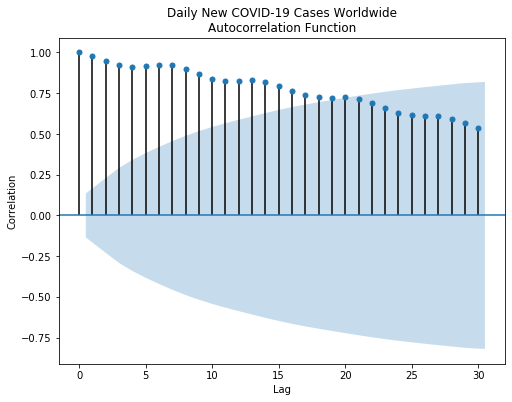

In [49]:
from statsmodels.graphics.tsaplots import plot_acf

ser, max_lag = load_data(), 30

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plot_acf(ser, ax, lags=max_lag, title="Daily New COVID-19 Cases Worldwide\nAutocorrelation Function")
ax.set_xlabel(r"Lag")
ax.set_ylabel(r"Correlation")

del fig, ax, ser, max_lag, plot_acf

In [50]:
from statsmodels.tsa.stattools import pacf
def calc_pacf(ser, max_lag):
    """
    Takes a series and calculates the PACF
    """
    
    ans_pacf = pacf(ser, nlags = max_lag)

    
    return ans_pacf

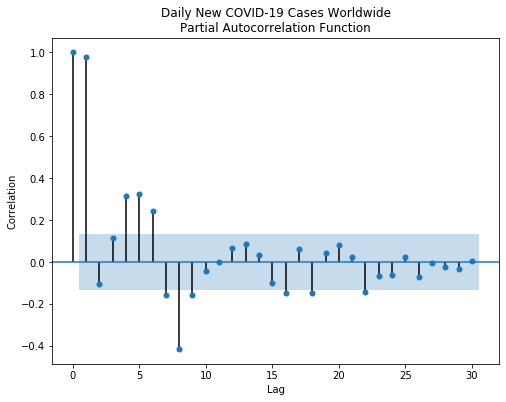

In [51]:
from statsmodels.graphics.tsaplots import plot_pacf

ser, max_lag = load_data(), 30

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plot_pacf(ser, ax, lags=max_lag, title="Daily New COVID-19 Cases Worldwide\nPartial Autocorrelation Function")
ax.set_xlabel(r"Lag")
ax.set_ylabel(r"Correlation")

del fig, ax, ser, max_lag, plot_pacf

In [55]:
from statsmodels.tsa.arima.model import ARIMA

def arma_log_ret(ser, p, q, num_forecasts):
    """
    Takes a series and fits an ARMA(p, q) model on log return. 
    Returns a number of forecasts as specified by num_forecasts. 
    """

    df = calc_log_ret(ser['2020-04-01':])
    mod = ARIMA(df, order =(p,0,q))
    res = mod.fit()
    
    import datetime
    delta = datetime.timedelta(days=num_forecasts - 1)
    start = pd.to_datetime('2020-08-22')
    dates= pd.date_range(start, start+delta)
    forecasts = res.forecast(steps = num_forecasts)

    result = []
    for i in range(len(forecasts)):
        if i == 0:
            result.append(np.exp(forecasts[i]+np.log(ser.iloc[-1])))
        else:
            result.append(np.exp(forecasts[i]+np.log(result[i-1])))
    
    forecasts = pd.Series(result, index = dates)

    
    return forecasts


In [56]:
ser = load_data()
p, q, num_forecasts = 7, 7, 20

forecasts = arma_log_ret(ser, p, q, num_forecasts)
actual = pd.read_pickle("../Smoothing and forecasting on TimeSeries/actual.pkl")
rmse = np.sqrt(np.mean((actual - forecasts) ** 2))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ser, label="Original")
ax.plot(ser[-1:].append(forecasts), label="Forecasted")
ax.plot(ser[-1:].append(actual), label="Actual")

ax.set_xlabel("Day")
ax.set_title("Daily New COVID-19 Cases Worldwide\n" + f"A {len(forecasts)}-day Forecast, RMSE = {rmse: .2f}")
ax.legend()

del fig, ax, ser, p, q, num_forecasts, forecasts, actual

AttributeError: 'Series' object has no attribute '_data'

In [57]:
from statsmodels.tsa.arima.model import ARIMA

def arma_first_diff(ser, p, q, num_forecasts):
    """
    Takes a series and fits an ARMA(p, q) model on first-order diff. 
    Returns a number of forecasts as specified by num_forecasts. 
    """
    
    mod = ARIMA(ser, order =(p,1,q))
    res = mod.fit()
    forecasts = res.forecast(steps = num_forecasts)

    return forecasts

In [59]:
ser = load_data()
p, q, num_forecasts = 7, 7, 20

forecasts = arma_first_diff(ser, p, q, num_forecasts)
actual = pd.read_pickle("../Smoothing and forecasting on TimeSeries/actual.pkl")
rmse = np.sqrt(np.mean((actual - forecasts) ** 2))

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ser, label="Original")
ax.plot(ser[-1:].append(forecasts), label="Forecasted")
ax.plot(ser[-1:].append(actual), label="Actual")

ax.set_xlabel("Day")
ax.set_title("Daily New COVID-19 Cases Worldwide\n" + f"A {len(forecasts)}-day Forecast, RMSE = {rmse: .2f}")
ax.legend()

del fig, ax, ser, p, q, num_forecasts, forecasts, actual

AttributeError: 'Series' object has no attribute '_data'

In [60]:
def load_data():
    df = pd.read_csv('../Smoothing and forecasting on TimeSeries/time_series_covid19_confirmed_global.csv')

    df = df.drop(columns = ['Province/State','Lat','Long'])
    df.sort_values('8/21/20', ascending = False, inplace = True)
    df = df.iloc[:5,:]
    df.set_index('Country/Region',inplace = True)
    df =df.T
    df.columns.name = None
    df.index = pd.to_datetime(df.index)
    
    lst=[]
    for i in range(len(df)-1):
        new = (df.iloc[i+1] - df.iloc[i]).astype(float)
        lst.append(new)

    df_new = pd.DataFrame(lst)
    df_new.index = df.index[1:]
    
    daily_new_cases = df_new
    # YOUR CODE HERE
    #raise NotImplementedError()
    
    return daily_new_cases

In [61]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults, VARResultsWrapper

def var_first_diff(df, p, num_forecasts):
    """
    Fits a VAR(p) model on the first-order diff on a df and makes num_forecasts forecasts
    """

    
    df_new = df.diff().dropna()
    model = VAR(df_new)
    var_res = model.fit(p)
    forecast = var_res.forecast(var_res.y, steps = num_forecasts)
    
    import datetime
    lst = []
    delta = datetime.timedelta(days=num_forecasts-1)
    start = pd.to_datetime('2020-08-22')
    dates= pd.date_range(start, start+delta)
    
    a = df.iloc[-1]
    b = []
    for i in forecast:
        a = a + i
        b.append(a)
    forecasts = pd.DataFrame(data = b, index = dates)

    
    return var_res, forecasts

In [64]:
def ar_first_diff(df, p, num_forecasts):
    """
    Fits an AR(p) model on the first-order diff on each time series in df and makes num_forecasts forecasts
    """
    df_new =pd.DataFrame()
    df_new['US'] = arma_first_diff(df.iloc[:,0], p,0, num_forecasts)
    df_new['Brazil'] = arma_first_diff(df.iloc[:,1], p,0, num_forecasts)
    df_new['India'] = arma_first_diff(df.iloc[:,2], p, 0,num_forecasts)
    df_new['Russia'] = arma_first_diff(df.iloc[:,3], p, 0,num_forecasts)
    df_new['South Africa'] = arma_first_diff(df.iloc[:,4], p, 0,num_forecasts)
    forecasts =df_new

    
    return forecasts

In [65]:
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.var_model import VARResults, VARResultsWrapper

def test_granger(df, p):
    """
    Fits a VAR(p) model on the input df and performs pairwise Granger Causality tests
    """
    df = df.diff().dropna()
    model = VAR(df)
    var_res = model.fit(p)


    b = []
    for i in df.columns:
        a = []
        for k in df.columns:
            a.append(var_res.test_causality(i,k, kind = 'f').pvalue)
        b.append(a)
    b = np.array(b)
    np.fill_diagonal(b,np.nan)
    granger_df = pd.DataFrame(data = b, columns = df.columns, index =df.columns)


    return granger_df

In [66]:
# Show the causality matrix

stu_df, p = load_data(), 7
stu_ans = test_granger(stu_df, 7)
caul_mtrx = stu_ans.rename(index={item: f"{item} caused by" for item in stu_ans.index})
caul_mtrx.where(caul_mtrx.isna(), caul_mtrx <= 0.01)

,US,Brazil,India,Russia,South Africa
US caused by,NaN,True,False,False,False
Brazil caused by,False,NaN,True,False,True
India caused by,False,True,NaN,False,True
Russia caused by,True,False,False,NaN,False
South Africa caused by,False,False,False,False,NaN
